In [1]:
source("forest_class.R")
require("kernlab")
require("aricode")
require("mclust")

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: GIGrvg

Loading required package: gtools


Attaching package: ‘gtools’


The following object is masked from ‘package:igraph’:

    permute


Loading required package: clue

Loading required package: kernlab

Loading required package: aricode

Loading required package: mclust

Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



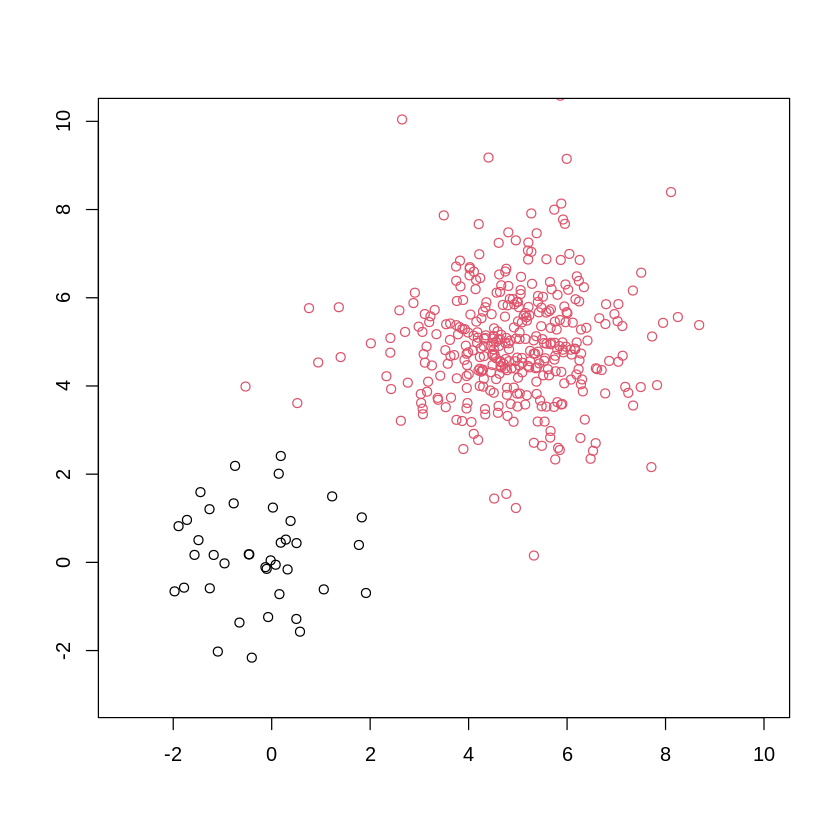

In [2]:
n =400
prob=c(0.1,0.9)

sep_b =5

df =5

p <- 2

true_membership<- numeric()

K = length(prob)

prob<- prob/sum(prob)


nk_list<- floor(n*prob)

y<- matrix(0,0,p)
k = 1
mu<- 0

for (n_k in nk_list){
        y<- rbind(y, matrix(rt(n_k*p,df = df),n_k,p)+mu)
        mu<- mu+ sep_b
        true_membership<- c(true_membership, rep(k,n_k))
        k<- k+1
    }         


plot(y[,1],y[,2], col=true_membership,xlab="",ylab="",xlim=c(-3,10),ylim=c(-3,10))


In [6]:
source("forest_class.R")

forest<- Forest$new()

forest$init(y,use_hierachical_prior=TRUE)

Loading required package: RcppML



In [7]:
experiment<- function(sep_b=3, n = 400, prob=c(0.3,0.6,0.1), df =5,steps=100,burnin=50){


            p <- 2

            true_membership<- numeric()

            K = length(prob)
    
            prob<- prob/sum(prob)
            

            nk_list<- floor(n*prob)

            y<- matrix(0,0,p)
            k = 1
            mu<- 0
    
            for (n_k in nk_list){
                    y<- rbind(y, matrix(rt(n_k*p,df = df),n_k,p)+mu)
                    mu<- mu+ sep_b
                    true_membership<- c(true_membership, rep(k,n_k))
                    k<- k+1
                }         
    

            forest<- Forest$new()

            forest$init(y,use_hierachical_prior=TRUE)
            forest$MCMC_run_single_graph(steps,burnin)

            trace_C<- forest$trace_C
            
    
            n = sum(nk_list)
            C_mat<- matrix(0,n,n)
    

            for(C in trace_C){
                C_mat = C_mat+ 1*outer(C,C,'==')
            }



            C_point_est<- matchAtoB(getPointEstC(C_mat,K),true_membership)

            accu<- clusteringAccu(C_point_est,true_membership)

            ari <- adjustedRandIndex(C_point_est,true_membership)

            nmi<- NMI(C_point_est,true_membership)
    
    
            c(accu,ari,nmi)
    }

In [8]:
experiment(sep_b=5, n = 400, prob=c(0.5,0.5), df =5)

  |==================================================| 100%

[1] 0.9850000 0.9407516 0.8926736

In [9]:
res1 <- sapply(c(1:10), function(i) experiment(sep_b=5, n = 400, prob=c(0.5,0.5), df =5))
res2 <- sapply(c(1:10), function(i) experiment(sep_b=5, n = 400, prob=c(0.3,0.7), df =5))
res3 <- sapply(c(1:10), function(i) experiment(sep_b=5, n = 400, prob=c(0.1,0.9), df =5))

list_res<- list(res1,res2,res3)

# save(list_res,file="res_uq_vs_accu_unbalanced_sepb5.RDa")




  |========================                          |  49%

In [13]:
load(file="res_uq_vs_accu_unbalanced_sepb5.RDa")


In [17]:
prob_list <- c(0.5,0.3,0.1)

require("ggplot2")
require("reshape")

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


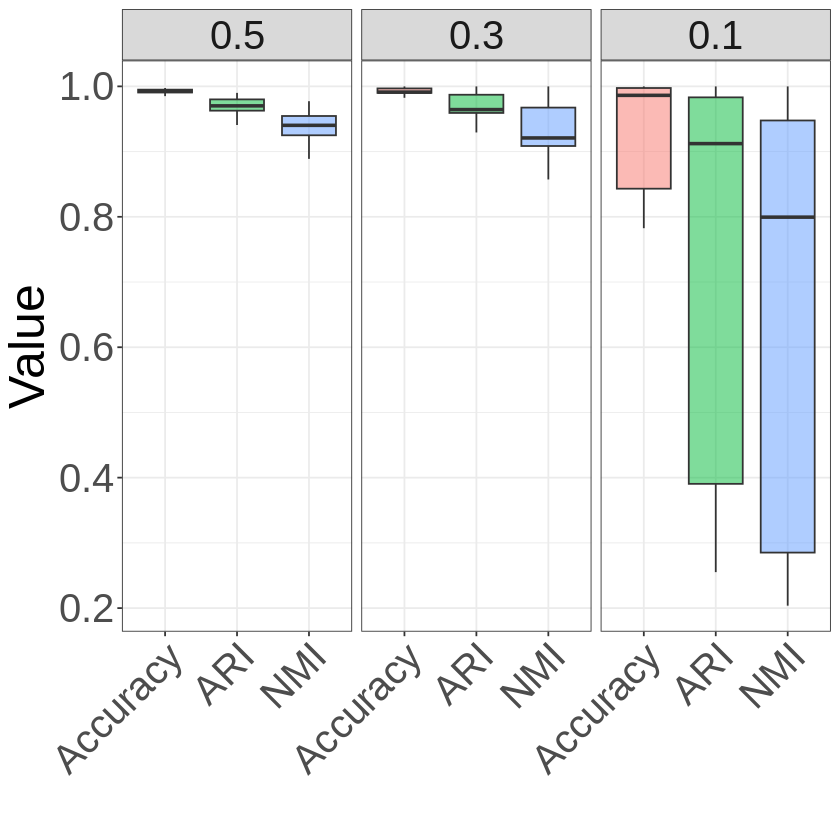

In [18]:
df<- data.frame()

for(k in 1:3){

    res<- t(list_res[[k]])

    colnames(res)<- c("Accuracy", "ARI", "NMI")
    
    df<- rbind(df, cbind(melt(res), prob_list[k]))
    # df<- rbind(df, )
}

colnames(df)<- c("index", "Score", "Value", "Prob1")
df$Prob1<- factor(df$Prob1, levels = c(0.5,0.3,0.1))

ggplot(df, aes(x = Score, y = Value, fill= Score)) +
facet_grid(~ Prob1) +  geom_boxplot(alpha = 0.5, outlier.shape = "")+
  xlab("Proportion of Cluster 1") +
   ylab("Value")+theme_bw() + 
theme(text = element_text(size = 30),axis.text.x = element_text(angle = 45, hjust = 1),
      axis.title.x = element_text(vjust = 1, hjust = 9),
     legend.position = "none"
     )
